# Strike Risk
The pnl from selling options is dependent on the path taken by the underlying security over the life of the option. This path dependence (not to be confused with path dependent options) introdudes an additional level of complexity when trying to simulated historical returns for option selling programs. The following workbook illustrates this path dependency

In [1]:
import pyfolio as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import nest_asyncio

opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

from option_simulation import OptionSimulation, OptionTrades
from option_utilities import plot_performance_quad, perf_stats
%time opt_sim = OptionSimulation(update_simulation_data=False)

CPU times: user 807 ms, sys: 29.3 ms, total: 836 ms
Wall time: 281 ms


In [2]:
%time sim_output = [opt_sim.trade_sim(-1, 2, trade_day_type=day_type) \
                    for day_type in ['EOM',(0,22), (1,22), (2,22), (3,22), (4,22), (5,22), (6,22), (7,22), (8,22), (9,22), \
                                     (10,22), (11,22), (12,22), (13,22), (14,22), (15,22), (16,22), (17,22), (18,22), (19,22), \
                                     (20,22), (21,22)]]
#  'EOM', '3MON', '3TUE', '3WED', '3THU',    

Running Simulation - trade_day_type:EOM | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(0, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(1, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(2, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(3, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(4, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(5, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(6, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(7, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(8, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(9, 22) | Z-score -1 | Duration 2 | Option Type:P
Running Simulation - trade_day_type:(10, 22) | Z-score -1 

In [3]:
opt_trade = [OptionTrades(sim, leverage=2) for sim in sim_output]
performance = [trade.performance_summary for trade in opt_trade]
perf = pd.concat(performance, axis=1, sort=False)
perf.style


,EOMP-1L2.0,"(0, 22)P-1L2.0","(1, 22)P-1L2.0","(2, 22)P-1L2.0","(3, 22)P-1L2.0","(4, 22)P-1L2.0","(5, 22)P-1L2.0","(6, 22)P-1L2.0","(7, 22)P-1L2.0","(8, 22)P-1L2.0","(9, 22)P-1L2.0","(10, 22)P-1L2.0","(11, 22)P-1L2.0","(12, 22)P-1L2.0","(13, 22)P-1L2.0","(14, 22)P-1L2.0","(15, 22)P-1L2.0","(16, 22)P-1L2.0","(17, 22)P-1L2.0","(18, 22)P-1L2.0","(19, 22)P-1L2.0","(20, 22)P-1L2.0","(21, 22)P-1L2.0"
StartDate,"Jan 30, 2004","Jan 02, 2004","Jan 05, 2004","Jan 06, 2004","Jan 07, 2004","Jan 08, 2004","Jan 09, 2004","Jan 12, 2004","Jan 13, 2004","Jan 14, 2004","Jan 15, 2004","Jan 16, 2004","Jan 20, 2004","Jan 21, 2004","Jan 22, 2004","Jan 23, 2004","Jan 26, 2004","Jan 27, 2004","Jan 28, 2004","Jan 29, 2004","Jan 30, 2004","Feb 02, 2004","Feb 03, 2004"
EndDate,"Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019","Apr 02, 2019"
Leverage,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
ZScore,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Avg_Days,35.285,33.0136,33.2046,33.3565,33.2733,33.3282,32.1949,32.2214,32.7828,33.27,33.4705,33.196,33.7726,33.9537,34.1237,33.638,32.9853,33.4444,32.8961,32.3247,32.6176,32.4469,32.7277
annual_return,0.0976755,0.0690979,0.0803022,0.0885489,0.0730787,0.0796471,0.0794073,0.08249,0.0652861,0.0654234,0.0663576,0.0765444,0.0787949,0.0809925,0.0812028,0.0823515,0.0963102,0.0891896,0.0949083,0.0867984,0.109528,0.102355,0.0723027
annual_volatility,0.13338,0.125771,0.122146,0.120649,0.124077,0.131618,0.119723,0.133495,0.138379,0.134801,0.137572,0.130108,0.124648,0.125103,0.120936,0.118824,0.126632,0.132968,0.121386,0.126411,0.134926,0.116757,0.123584
sharpe_ratio,0.76618,0.595786,0.694878,0.764939,0.63208,0.649337,0.698853,0.661332,0.527035,0.53817,0.536284,0.632368,0.671395,0.68575,0.707449,0.7269,0.790512,0.709941,0.808811,0.72298,0.83661,0.893737,0.627946
calmar_ratio,0.295965,0.184533,0.229955,0.250135,0.195523,0.218055,0.281158,0.246207,0.200487,0.202722,0.173152,0.241635,0.246991,0.22108,0.195564,0.202815,0.251961,0.23385,0.281627,0.245664,0.347456,0.380444,0.193653
stability_of_timeseries,0.989264,0.933298,0.968429,0.978958,0.942681,0.9556,0.980201,0.984213,0.97138,0.978206,0.970815,0.987648,0.981064,0.981077,0.974113,0.974558,0.984786,0.984574,0.982851,0.977237,0.994038,0.991759,0.95627


# Path dependence
Selling options produces a path dependent return stream. Annual returns range from 10.9% down to 6.4% with a mean of 8.17%. Path dependence is sometimes referred to as strike risk. In order to mitigate this we need to vary the strikes. The way to do this is to vary the dates on which you trade. One solution would be to trade a slice every day of the month. This would guarrantee that you minimize path dependency. However that could get pretty messy from a trading standpoint. An alternative might be to trade twice a month, say once at the end of month and once at mid-month. This might get you most of the benefit while minimizing the trading hassle.
Another thing to consider is that letting options expire might expose you to more strike risk than usual. It may be that larege market participants are incentivised to "bang the close" on expiration dates.
The chart below shows the different annualized returns for writing puts at different times. Each point corresponds to a business day of the month when options are written.

Mean annual return is 8.19%
Max annual return is 10.95%
Min annual return is 6.53%


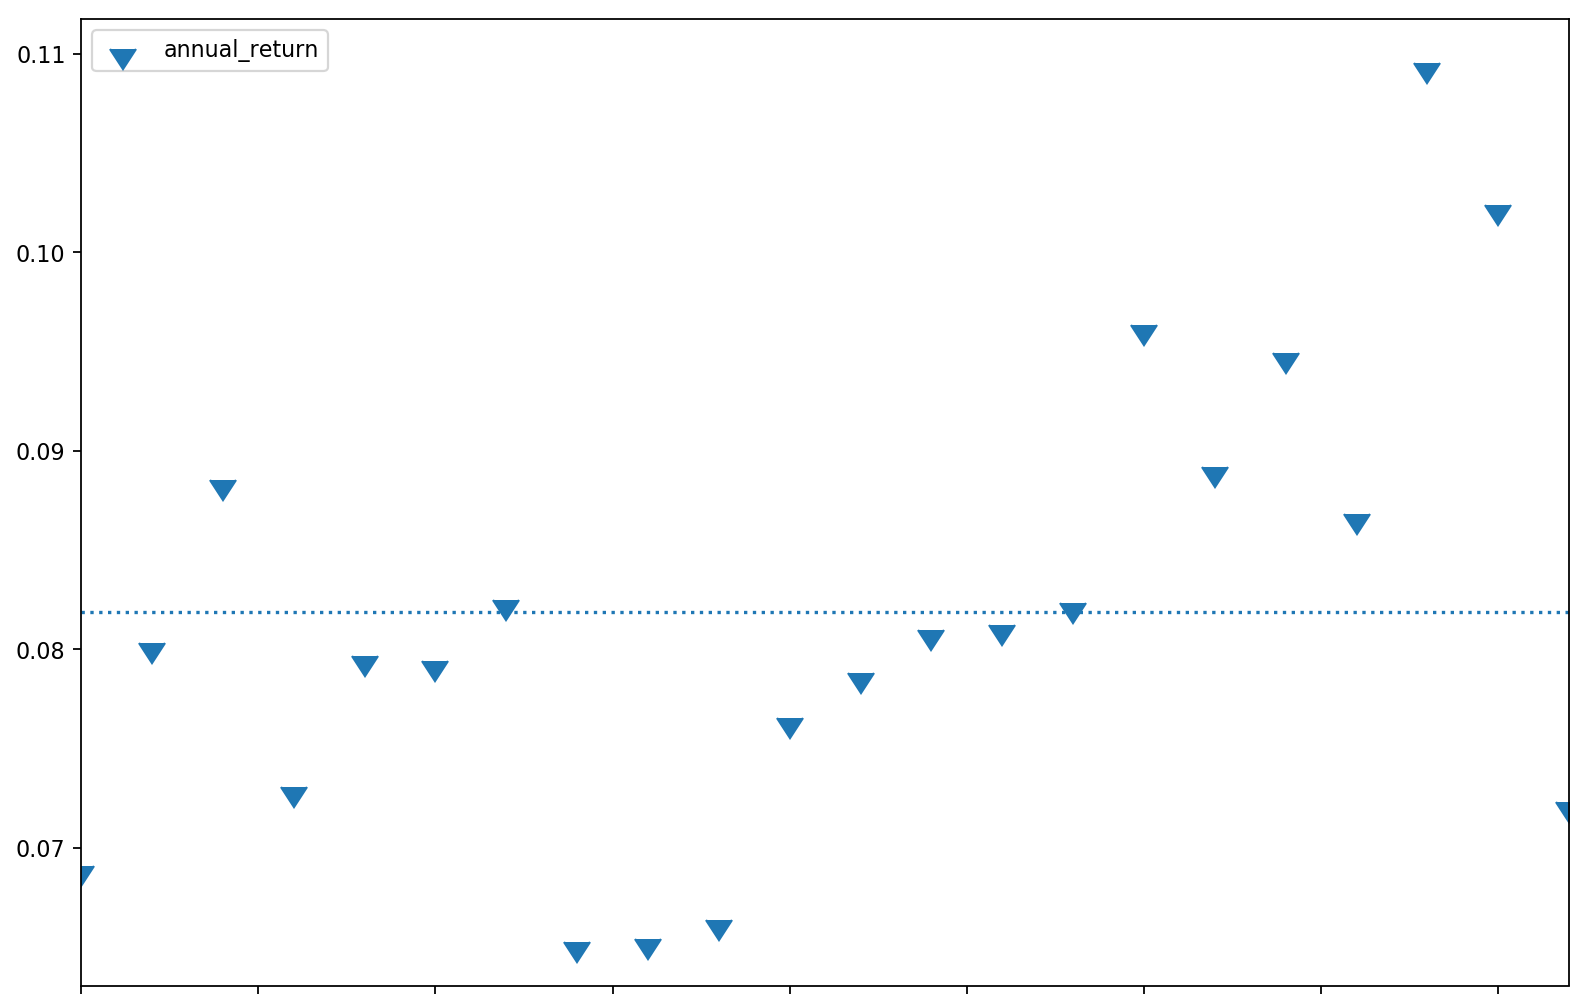

In [4]:
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
_ = perf.loc['annual_return'][1:].plot(legend=True, linestyle='', marker=11, markersize=12)
plt.autoscale(enable=True, axis='x', tight=True)
print('Mean annual return is {:.2f}%'.format(perf.loc['annual_return'][1:].mean()*100))
print('Max annual return is {:.2f}%'.format(perf.loc['annual_return'][1:].max()*100))
print('Min annual return is {:.2f}%'.format(perf.loc['annual_return'][1:].min()*100))
_ = plt.axhline(perf.loc['annual_return'][1:].mean(), linestyle=':')

# Lowest return: performance quad 
Trading on the 7th business day of the month has generated the lowest annualized return. Looking at the distribution of monthly returns it looks like this might be coming from the two additional outliers on September 2008 (-8.8%) and December 2008 (-8.1%). In addition, the recovery year of 2009 was distinctly weaker.

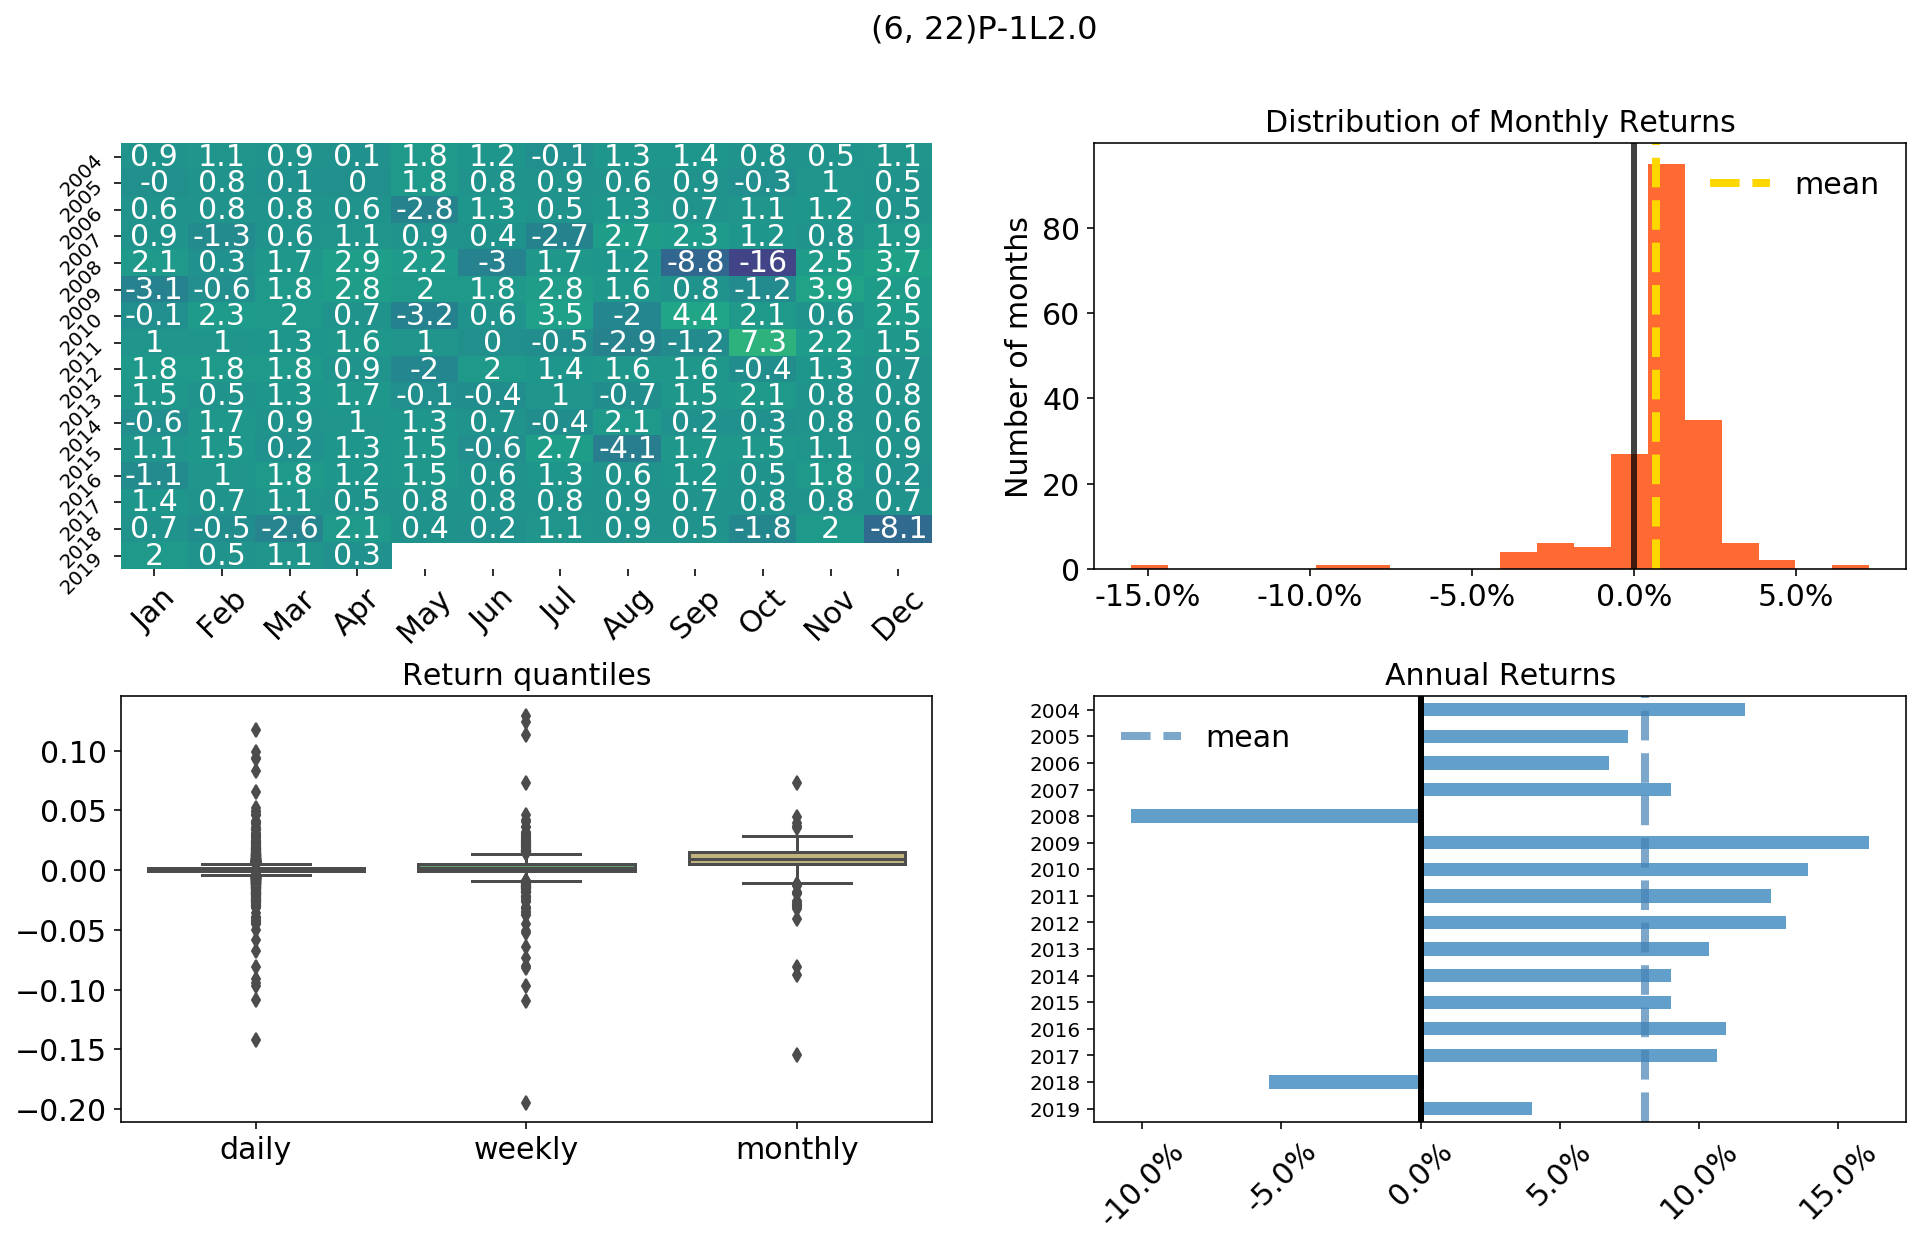

In [11]:
returns_low = opt_trade[7].returns
plot_performance_quad(returns_low, font_size=15)

# Highest month: performance quad
Trading on the 19th business day of the month has generated the highest annualized return

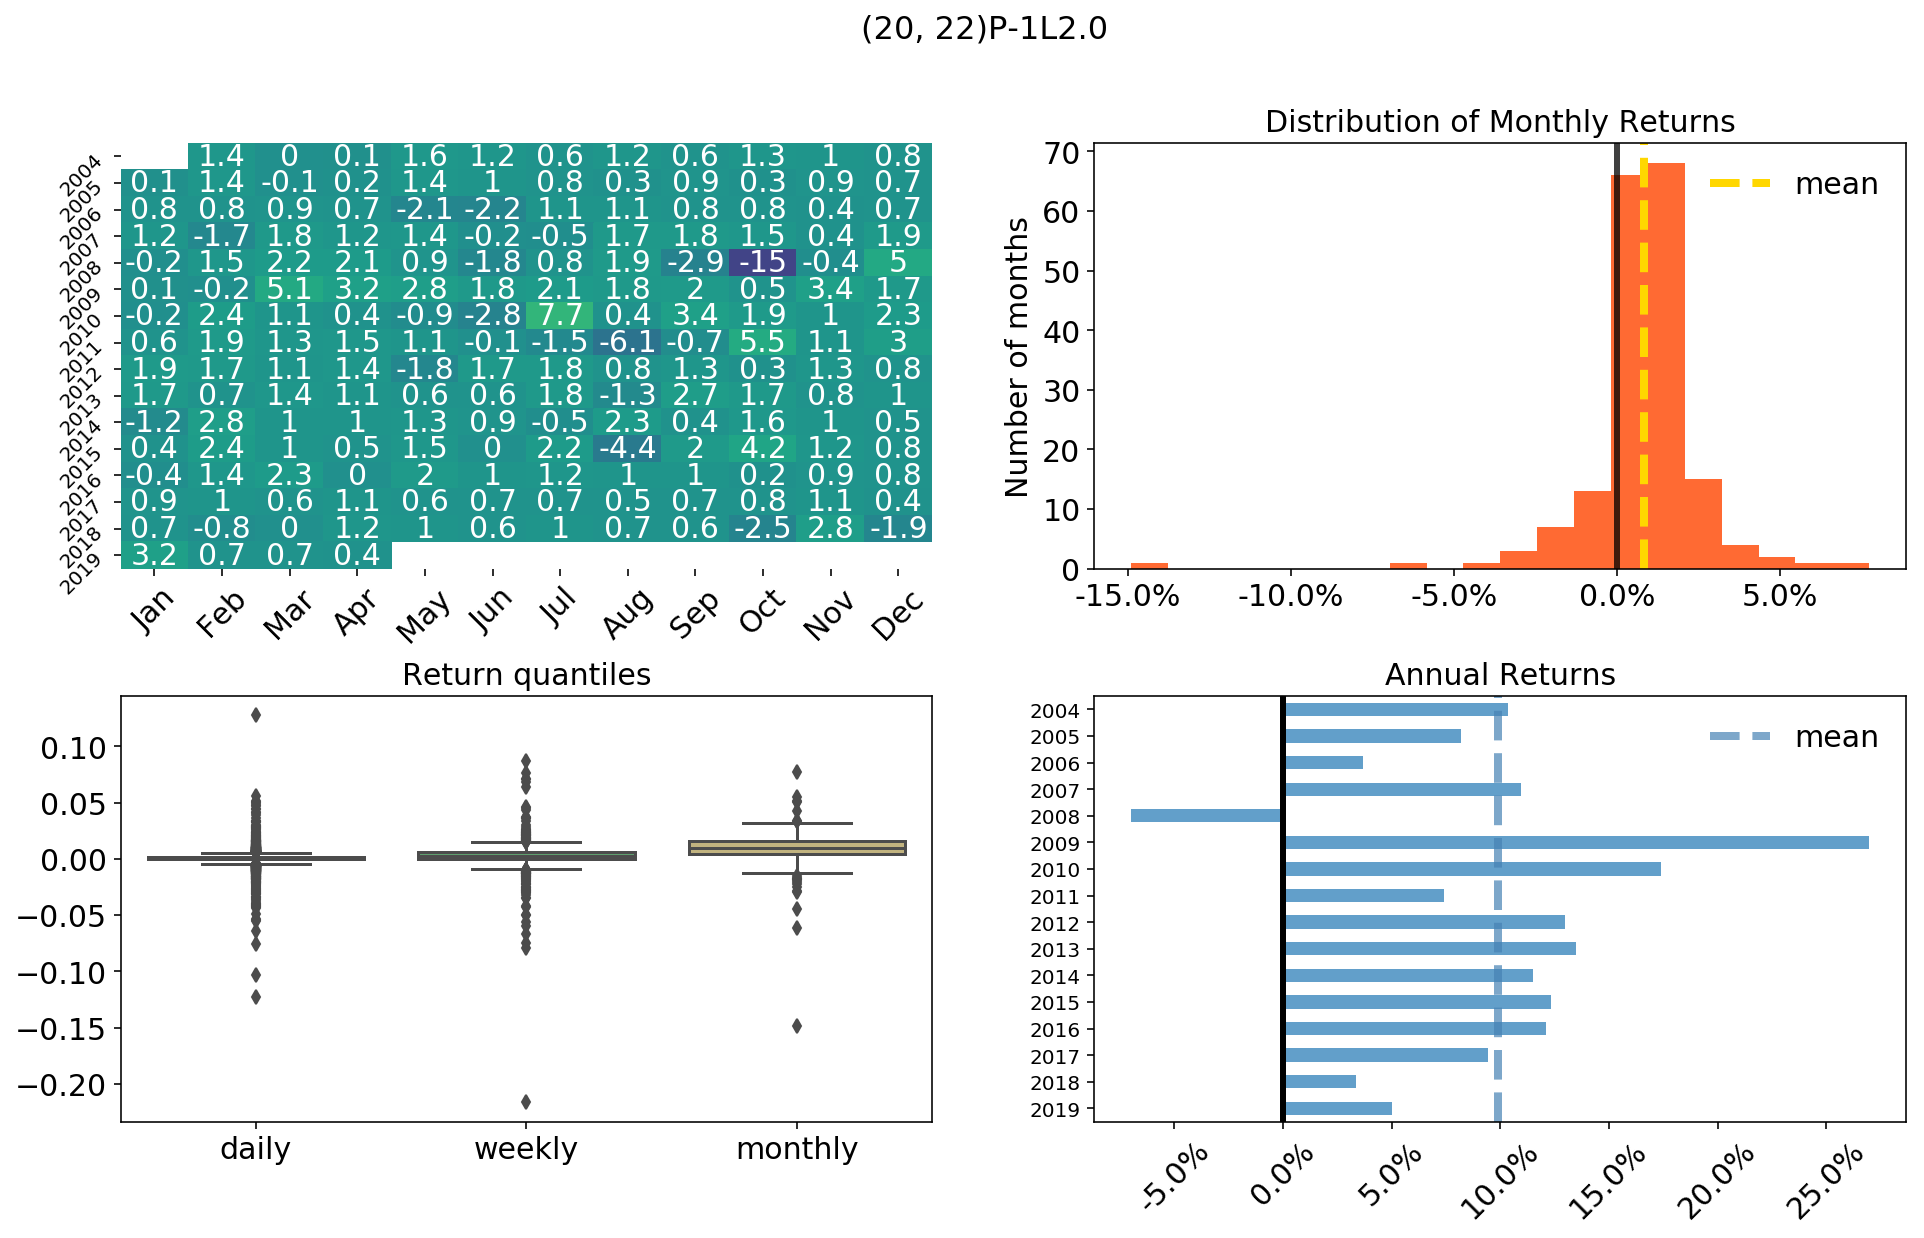

In [10]:
returns_high = opt_trade[-2].returns
plot_performance_quad(returns_high, font_size=15)

,"(20, 22)P-1L2.0","(6, 22)P-1L2.0"
2004,10.36%,11.64%
2005,8.18%,7.46%
2006,3.68%,6.76%
2007,10.97%,9.00%
2008,-6.97%,-10.38%
2009,26.98%,16.11%
2010,17.42%,13.91%
2011,7.39%,12.58%
2012,12.99%,13.12%
2013,13.48%,10.37%


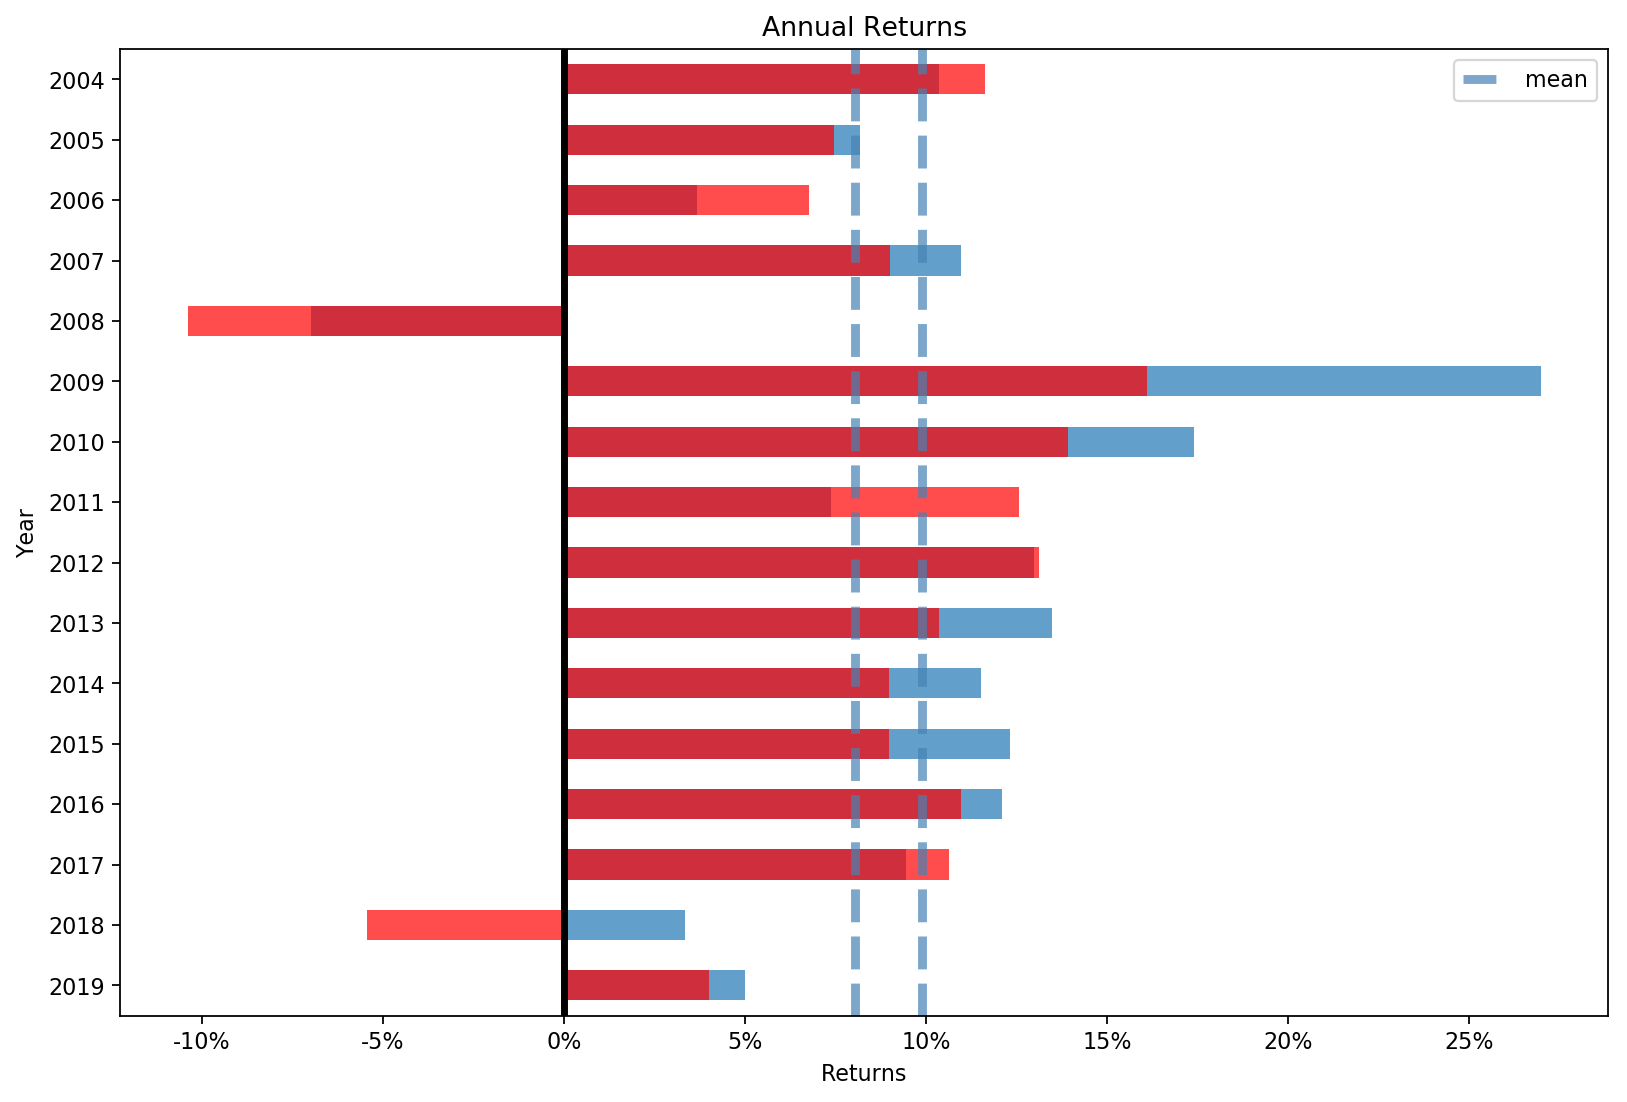

In [12]:
annual_returns_high = pf.timeseries.aggregate_returns(returns_high, 'yearly')
annual_returns_low = pf.timeseries.aggregate_returns(returns_low, 'yearly')
returns_compare = pd.concat([annual_returns_high, annual_returns_low], axis=1)
display(returns_compare.style.format('{:.2%}'))

fig, ax = plt.subplots(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
hm = pf.plot_annual_returns(returns_high, ax=ax)
hm = pf.plot_annual_returns(returns_low, ax=ax, color='red')

In [15]:
monthly_perf=[pf.timeseries.aggregate_returns(trade.returns, 'monthly')  for trade in opt_trade]
monthly_perf_df = pd.concat(monthly_perf, axis=1)

yearly_perf=[pf.timeseries.aggregate_returns(trade.returns, 'yearly')  for trade in opt_trade]
yearly_perf_df = pd.concat(yearly_perf, axis=1)

display(monthly_perf_df.style.format('{:.2%}'))
display(yearly_perf_df.style.format('{:.2%}'))

,EOMP-1L2.0,"(0, 22)P-1L2.0","(1, 22)P-1L2.0","(2, 22)P-1L2.0","(3, 22)P-1L2.0","(4, 22)P-1L2.0","(5, 22)P-1L2.0","(6, 22)P-1L2.0","(7, 22)P-1L2.0","(8, 22)P-1L2.0","(9, 22)P-1L2.0","(10, 22)P-1L2.0","(11, 22)P-1L2.0","(12, 22)P-1L2.0","(13, 22)P-1L2.0","(14, 22)P-1L2.0","(15, 22)P-1L2.0","(16, 22)P-1L2.0","(17, 22)P-1L2.0","(18, 22)P-1L2.0","(19, 22)P-1L2.0","(20, 22)P-1L2.0","(21, 22)P-1L2.0"
2004,11.91%,9.24%,11.51%,8.34%,11.17%,11.87%,9.82%,11.64%,11.87%,9.43%,10.77%,9.00%,10.38%,9.81%,10.50%,11.15%,11.38%,10.68%,9.76%,10.71%,10.65%,10.36%,6.91%
2005,8.08%,8.45%,8.79%,6.78%,6.90%,7.35%,7.41%,7.46%,5.86%,5.33%,6.12%,7.76%,8.64%,5.58%,9.41%,6.95%,8.21%,6.88%,7.92%,6.00%,6.62%,8.18%,7.53%
2006,8.97%,8.98%,11.18%,10.70%,9.55%,7.22%,8.17%,6.76%,8.15%,8.55%,8.95%,9.24%,8.20%,9.07%,9.91%,10.89%,10.04%,8.95%,7.17%,6.59%,6.16%,3.68%,5.99%
2007,8.61%,13.30%,9.68%,9.60%,8.12%,7.81%,10.51%,9.00%,5.87%,5.22%,-1.64%,8.40%,2.63%,6.43%,6.05%,5.93%,8.38%,9.12%,9.56%,8.97%,10.25%,10.97%,11.12%
2008,-10.06%,-23.16%,-17.47%,-17.00%,-21.27%,-16.85%,-11.06%,-10.38%,-11.63%,-13.72%,-12.80%,-11.57%,-15.36%,-17.57%,-24.04%,-23.65%,-18.56%,-14.84%,-16.79%,-18.86%,9.09%,-6.97%,-25.40%
2009,24.85%,10.34%,14.88%,21.53%,12.91%,9.74%,8.38%,16.11%,14.19%,21.10%,26.95%,28.44%,31.62%,30.97%,33.31%,33.57%,33.75%,27.08%,27.33%,29.59%,27.95%,26.98%,24.68%
2010,14.70%,8.48%,9.68%,9.92%,8.13%,8.24%,15.44%,13.91%,9.65%,14.72%,13.09%,13.63%,12.33%,15.62%,17.19%,18.62%,16.87%,16.60%,17.05%,13.25%,14.09%,17.42%,17.01%
2011,12.92%,2.07%,2.05%,11.75%,7.35%,15.15%,9.65%,12.58%,1.13%,-0.32%,-6.43%,-1.69%,4.56%,0.84%,7.84%,11.89%,14.04%,11.05%,12.19%,11.90%,7.93%,7.39%,-3.56%
2012,15.37%,15.72%,14.91%,15.95%,14.88%,15.42%,14.26%,13.12%,7.08%,9.06%,12.13%,15.22%,14.25%,14.66%,14.85%,13.48%,13.31%,14.28%,14.95%,16.78%,13.14%,12.99%,15.66%
2013,12.87%,12.64%,13.53%,12.73%,11.48%,12.66%,11.21%,10.37%,11.01%,10.91%,11.02%,12.19%,12.34%,13.18%,11.62%,13.15%,12.72%,13.41%,12.70%,13.33%,13.09%,13.48%,13.39%


In [26]:
# Average of every run
all_returns = [trade.returns for trade in opt_trade]
all_returns_df = pd.concat(all_returns, axis=1)
avg_return = all_returns_df.mean(axis=1)
perf_avg = perf_stats(avg_return)
perf_avg = perf_avg.rename('Average')
# Trade end of month and 10th business day
mid_eom_returns_df = pd.concat([opt_trade[0].returns, opt_trade[11].returns], axis=1)
mid_eom_returns = mid_eom_returns_df.sum(axis=1) / 2
perf_mid_eom = perf_stats(mid_eom_returns)
perf_mid_eom = perf_mid_eom.rename('Mid+EOM')

pd.concat([perf_mid_eom, perf_avg], axis=1)

,Mid+EOM,Average
StartDate,"Jan 20, 2004","Jan 05, 2004"
EndDate,"Apr 02, 2019","Apr 02, 2019"
annual_return,0.087456,0.0842031
annual_volatility,0.128044,0.119107
sharpe_ratio,0.719397,0.73917
calmar_ratio,0.275516,0.254513
stability_of_timeseries,0.990175,0.983356
max_drawdown,-0.317426,-0.33084
omega_ratio,1.23497,1.23322
sortino_ratio,0.984942,0.977563
